# Plan Cropping

In this example, we show how you can simplify any activities happening outside a defined "core" area.

Method:

1. Identify which legs touch the core area
2. Keep the relevant legs/activities and drop the remaining components
3. Infill: create any new legs between external activities as necessary
4. Ensure plan consistency: start/end times, sequences, etc
5. (optional) : Rename activities to "external"
6. (optional) : Crop the leg geometries to start/stop at the core area boundaries 

In [1]:
from copy import deepcopy

import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

from pam.activity import Activity, Leg, Plan
from pam.core import Household, Person, Population
from pam.operations import cropping
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY

## Data

Create a simple zoning system:

In [2]:
def test_zoning_system() -> gp.GeoDataFrame:
    """Dummy orthogonal zoning system."""
    zones = []
    labels = [chr(x) for x in range(97, 106)]
    for x in range(3):
        for y in range(3):
            zones.append(Polygon([(x, y), (x, y + 1), (x + 1, y + 1), (x + 1, y)]))
    zones_gdf = gp.GeoDataFrame({"zone": labels}, geometry=zones)
    zones_gdf.index = zones_gdf.zone

    return zones_gdf


zoning_system = test_zoning_system()

Create a simple plan:

In [3]:
plan = Plan()
plan.day = [
    Activity(seq=1, act="home", loc=Point(0.31, 0.81), start_time=mtdt(0), end_time=mtdt(420)),
    Leg(
        seq=1,
        mode="car",
        start_loc=Point(0.31, 0.81),
        end_loc=Point(0.12, 1.45),
        start_time=mtdt(420),
        end_time=mtdt(480),
        distance=1000,
    ),
    Activity(seq=2, act="shop", loc=Point(0.12, 1.45), start_time=mtdt(480), end_time=mtdt(510)),
    Leg(
        seq=2,
        mode="car",
        start_loc=Point(0.12, 1.45),
        end_loc=Point(0.84, 2.12),
        start_time=mtdt(510),
        end_time=mtdt(540),
        distance=1000,
    ),
    Activity(seq=3, act="work", loc=Point(0.84, 2.12), start_time=mtdt(540), end_time=mtdt(800)),
    Leg(
        seq=3,
        mode="walk",
        start_loc=Point(0.84, 2.12),
        end_loc=Point(1.90, 0.23),
        start_time=mtdt(800),
        end_time=mtdt(900),
        distance=1000,
    ),
    Activity(seq=4, act="medical", loc=Point(1.90, 0.23), start_time=mtdt(900), end_time=mtdt(960)),
    Leg(
        seq=4,
        mode="walk",
        start_loc=Point(1.90, 0.23),
        end_loc=Point(2.26, 0.24),
        start_time=mtdt(960),
        end_time=mtdt(990),
        distance=1000,
    ),
    Activity(seq=5, act="other", loc=Point(2.26, 0.24), start_time=mtdt(990), end_time=mtdt(1010)),
    Leg(
        seq=5,
        mode="walk",
        start_loc=Point(2.26, 0.24),
        end_loc=Point(2.77, 1.82),
        start_time=mtdt(1010),
        end_time=mtdt(1030),
        distance=1000,
    ),
    Activity(seq=6, act="other", loc=Point(2.77, 1.82), start_time=mtdt(1030), end_time=mtdt(1060)),
    Leg(
        seq=6,
        mode="walk",
        start_loc=Point(2.77, 1.82),
        end_loc=Point(1.88, 1.72),
        start_time=mtdt(1060),
        end_time=mtdt(1100),
        distance=1000,
    ),
    Activity(seq=7, act="other", loc=Point(1.88, 1.72), start_time=mtdt(1100), end_time=mtdt(1200)),
    Leg(
        seq=7,
        mode="car",
        start_loc=Point(1.88, 1.72),
        end_loc=Point(0.23, 0.10),
        start_time=mtdt(1200),
        end_time=mtdt(1210),
        distance=1000,
    ),
    Activity(seq=8, act="home", loc=Point(0.23, 0.10), start_time=mtdt(1210), end_time=END_OF_DAY),
]

hh = Household(1, loc=Point(0.31, 0.81))
population = Population()
person = Person(1)
person.plan = plan
hh.add(person)
population.add(hh)

The core area scope is defined as a geometry:

In [4]:
def plot_legs(plan: Plan):
    for i, leg in enumerate(plan.legs):
        path = cropping.get_leg_path(leg)
        plt.annotate(
            i,
            xy=(path.xy[0][1], path.xy[1][1]),
            xytext=(path.xy[0][0], path.xy[1][0]),
            arrowprops={"arrowstyle": "->", "color": "gray"},
        )

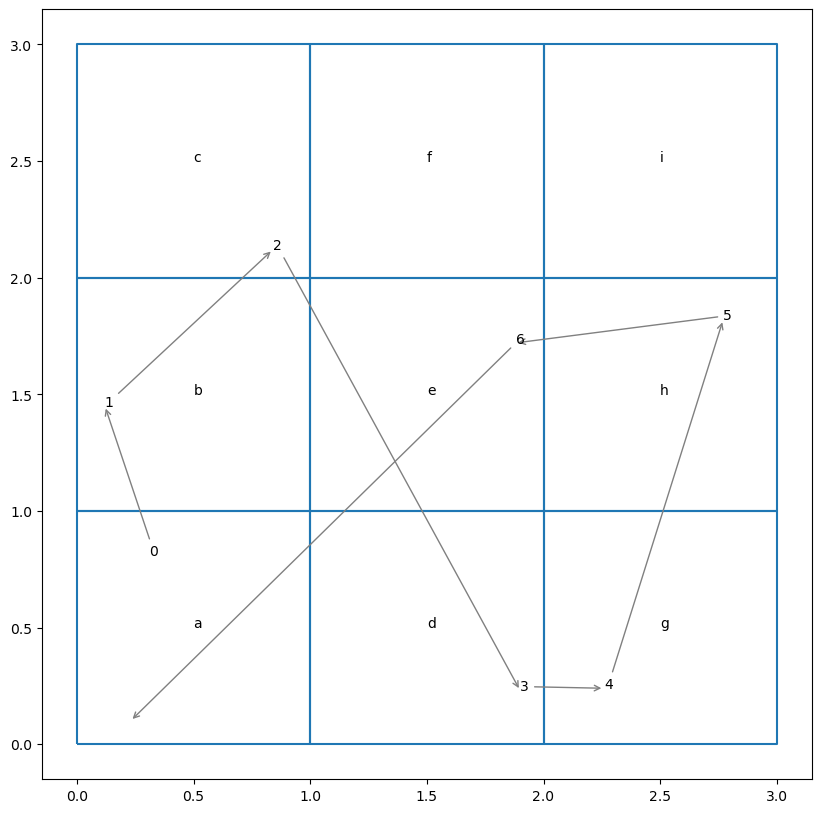

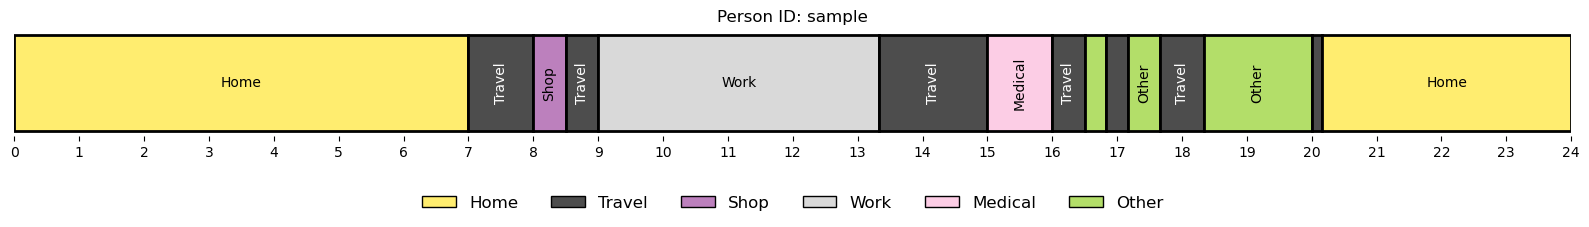

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zoning_system.boundary.plot(ax=ax)
for _i, irow in zoning_system.iterrows():
    x = irow.geometry.centroid.x
    y = irow.geometry.centroid.y
    plt.annotate(irow.zone, xy=(x, y))
plot_legs(plan)

plan.plot()

## Examples

### Example 1 - Internal-external trips

Trips that enter or exit the core area (here, zone `h`) are kept in the agent's plan:

In [6]:
boundary = zoning_system.loc["h"].geometry

# crop
plan_cropped = deepcopy(plan)
cropping.simplify_external_plans(plan_cropped, boundary)

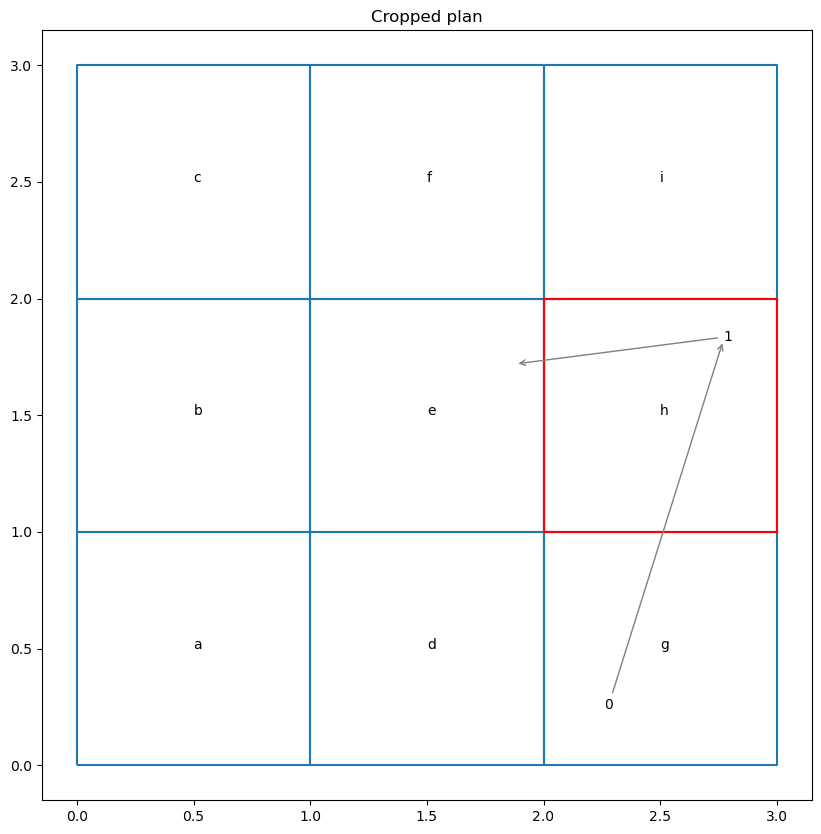

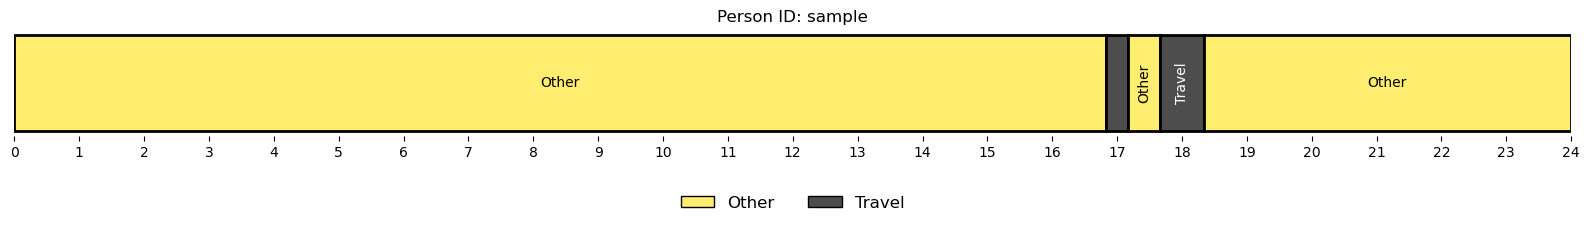

In [7]:
def plot_results(plan: Plan, boundary: gp.GeoDataFrame):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    zoning_system.boundary.plot(ax=ax)
    for _i, irow in zoning_system.iterrows():
        x = irow.geometry.centroid.x
        y = irow.geometry.centroid.y
        plt.annotate(irow.zone, xy=(x, y))
    gp.GeoSeries([boundary]).boundary.plot(ax=ax, color="red")
    plot_legs(plan)
    plt.title("Cropped plan")

    plan.plot()


plot_results(plan_cropped, boundary)

### Example 2 - Through trips

Any trips that are expected to go through the core area (as a straight-line path) are retained in the plan:

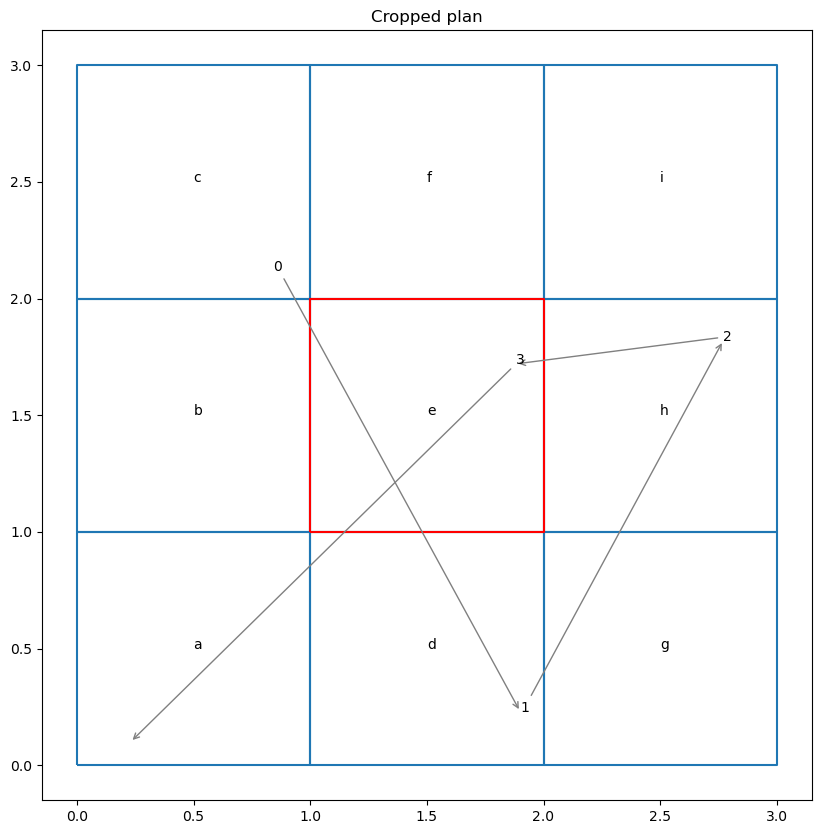

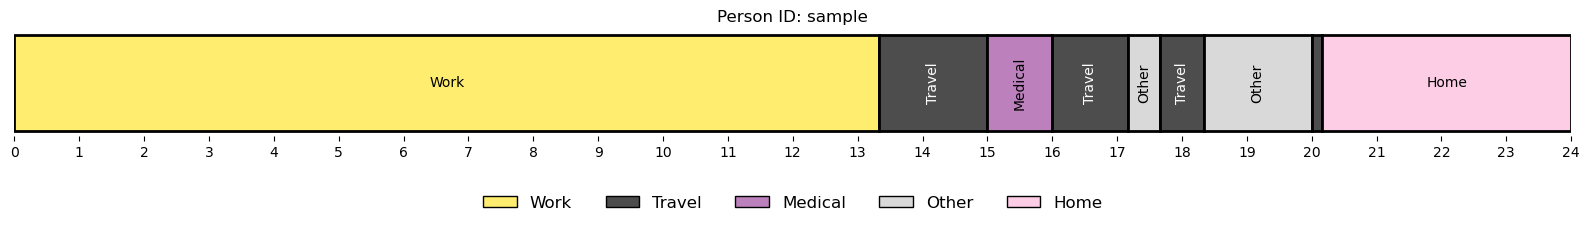

In [8]:
# define boundary
boundary = zoning_system.loc["e"].geometry

# crop
plan_cropped = deepcopy(plan)
cropping.simplify_external_plans(plan_cropped, boundary)


plot_results(plan_cropped, boundary)

### Example 3 - Snap trip ends to zone boundaries

By passing the `snap_to_boundary=True` argument, we can completely remove any leg parts that fall outside the core area:

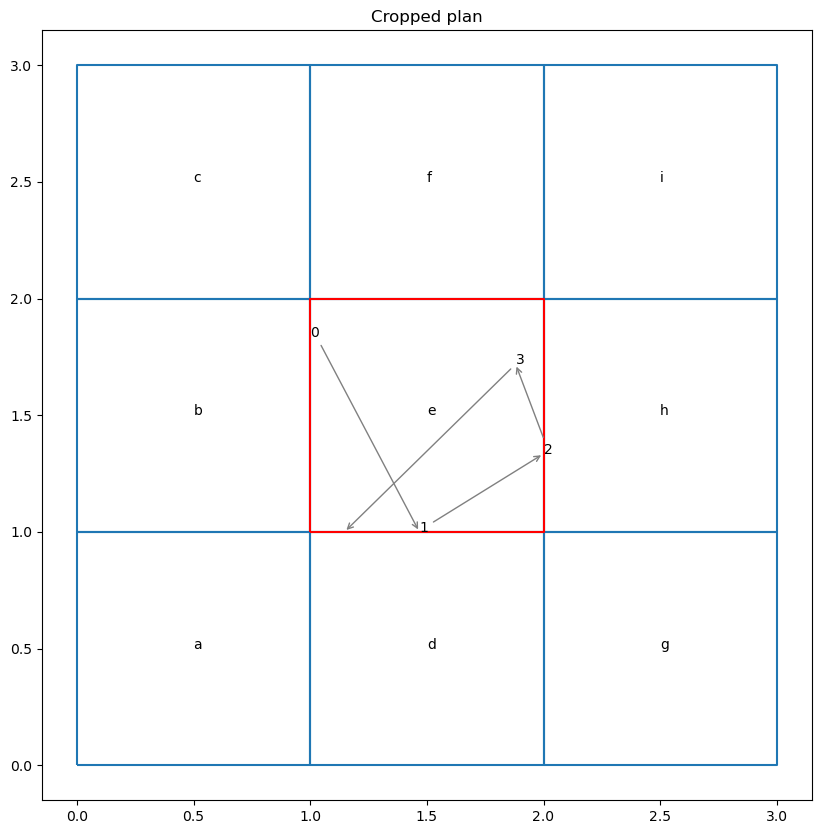

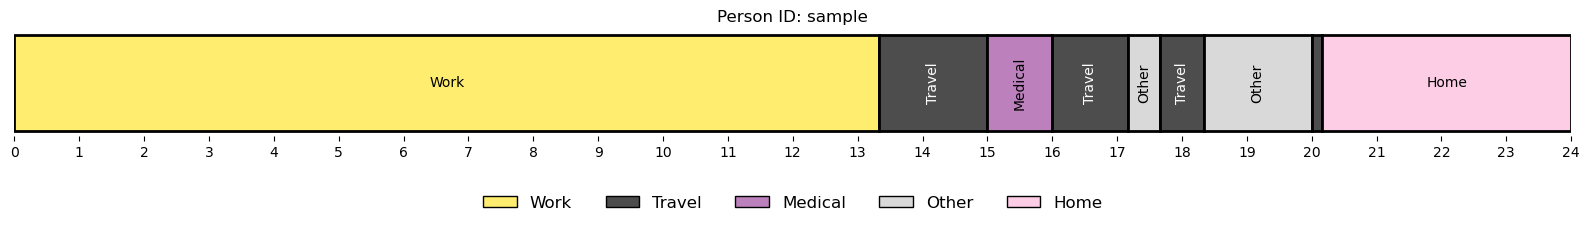

In [9]:
# crop
plan_cropped = deepcopy(plan)
cropping.simplify_external_plans(plan_cropped, boundary, snap_to_boundary=True)

# plot
plot_results(plan_cropped, boundary)

### Example 3 - Fully external plan

If no leg crosses the core area (here, zone i), then an empty plan is returned, and the person is removed from the population:

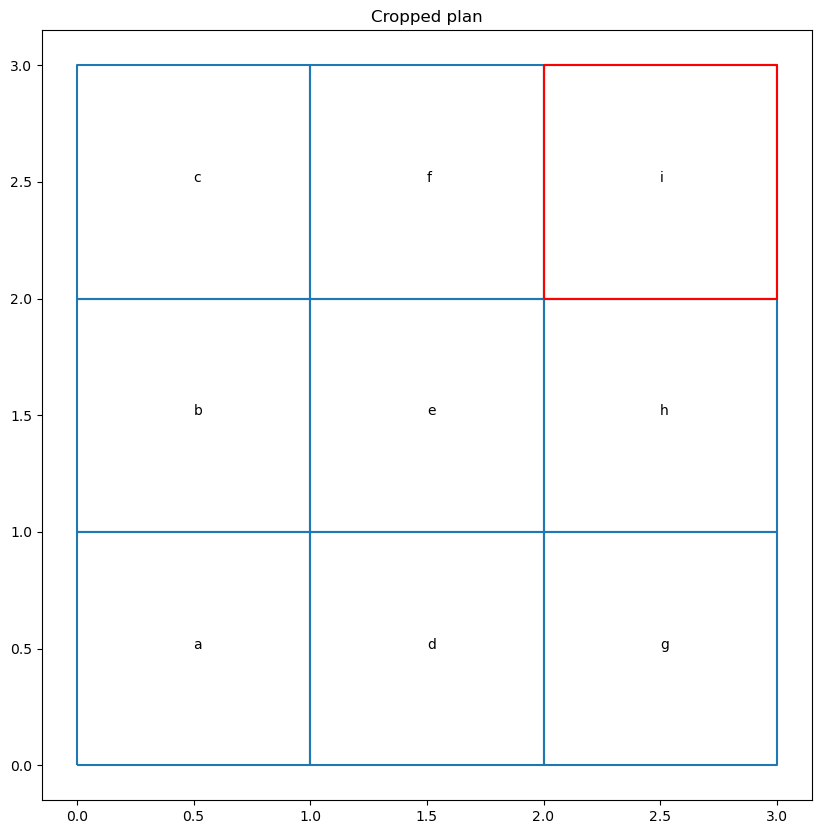

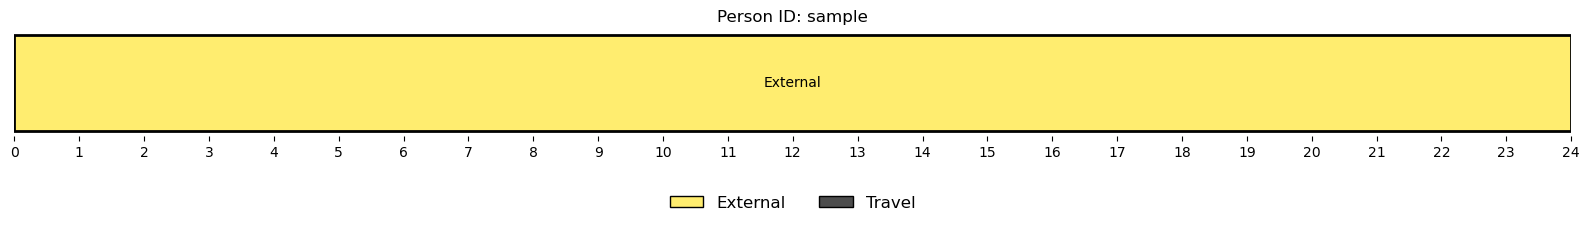

In [10]:
boundary = zoning_system.loc["i"].geometry

# crop
plan_cropped = deepcopy(plan)
cropping.simplify_external_plans(plan_cropped, boundary)

# plot
plot_results(plan_cropped, boundary)

Any agents with fully external plans are dropped entirely:

In [11]:
population_cropped = deepcopy(population)
assert len(population_cropped) == 1

# after simplification, there are no agents left
cropping.simplify_population(population_cropped, boundary)
assert len(population_cropped) == 0

### Example 4 - Fully internal plan

If all activities fall within the core area, plans remain unchanged:

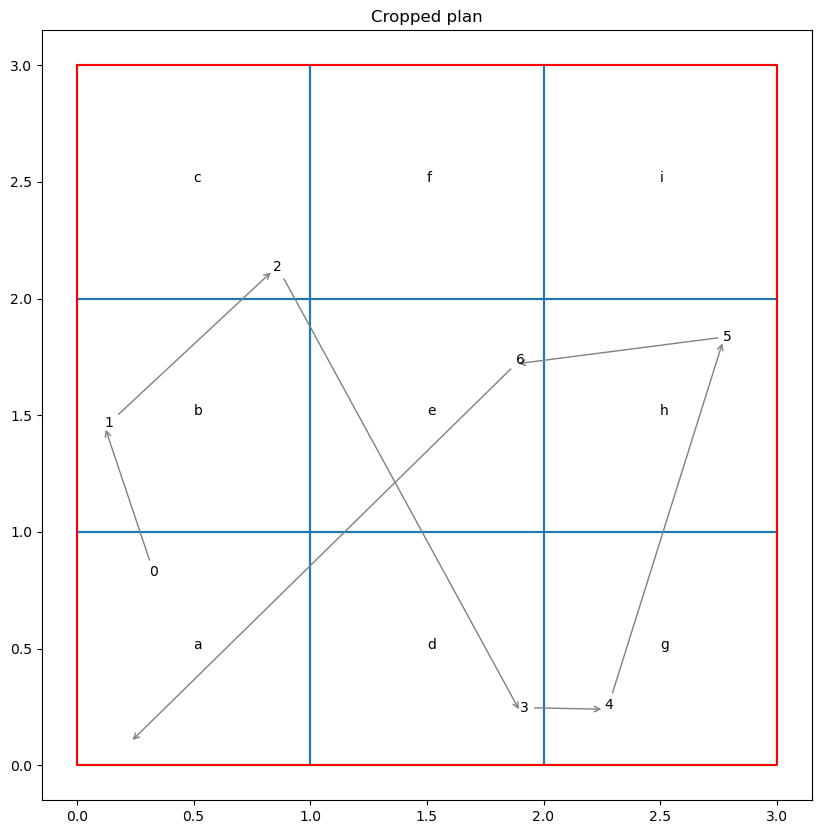

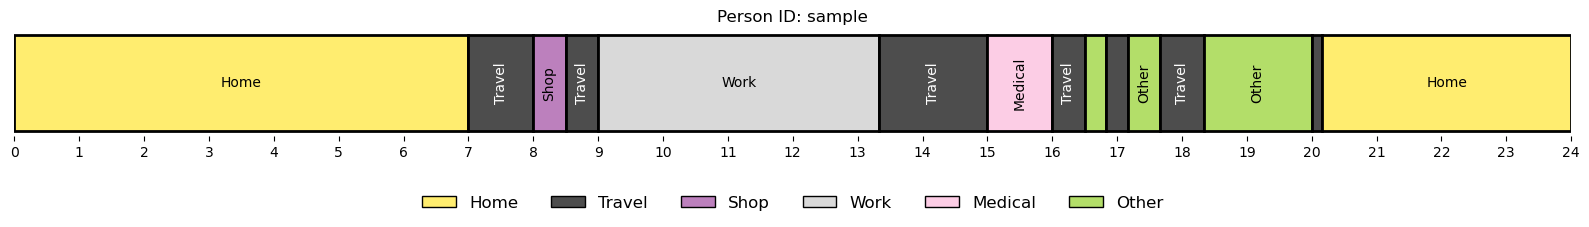

In [12]:
boundary = zoning_system.dissolve().geometry[0]

# crop
plan_cropped = deepcopy(plan)
cropping.simplify_external_plans(plan_cropped, boundary)

# plot
plot_results(plan_cropped, boundary)